In [153]:
import sys # for automation and parallelization
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [154]:
import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import unary_union
from shapely.geometry import Point, LineString, MultiPolygon, Polygon
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
import numpy as np
import time

In [155]:
# import helper functions 
# imports all helper functions stored in class "helpers" 
%run -i helperFunctions.py

<Figure size 432x288 with 0 Axes>

# Create zones and add basic information
## Zones Berliner Ortsteile, number of inhabitants 
Uses Berliner Ortsteile (n=98), source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s_wfs_alkis_ortsteile

Population data on bulding block level 2020, source: https://fbinter.stadt-berlin.de/fb/wfs/data/senstadt/s06_06ewdichte2020

In [156]:
input_path = './../../input/'
output_path = './../../output/'
model_path = './../../model/'

## Zones

Load zone data from the input files

### read in Berliner Ortsteile shapefile

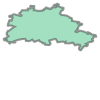

In [187]:
zones = gpd.read_file(input_path + "zones/Berliner_Ortsteile.shp")
zones = zones.to_crs(epsg=4326)
#hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)
hull = unary_union([x.buffer(1e-3) for x in zones['geometry']])
hull

In [188]:
zones.tail(10)

,uuid,sch,nam,gdf,bezeich,geometry
88,DEBE12YYJ000000B,110000121205,Frohnau,7839990.0,AX_KommunalesGebiet,"POLYGON ((13.28659 52.66007, 13.28717 52.65994..."
89,DEBE05YYQ000000D,110000050508,Falkenhagener Feld,6876159.0,AX_KommunalesGebiet,"POLYGON ((13.15567 52.56641, 13.15579 52.56639..."
90,DEBE05YYQ0000001,110000050504,Staaken,10887518.0,AX_KommunalesGebiet,"POLYGON ((13.14278 52.55219, 13.14321 52.55208..."
91,DEBE06YYA0000007,110000060607,Wannsee,23735618.0,AX_KommunalesGebiet,"POLYGON ((13.16655 52.44252, 13.16723 52.44112..."
92,DEBE05YYQ0000003,110000050509,Wilhelmstadt,10421573.0,AX_KommunalesGebiet,"POLYGON ((13.17876 52.53063, 13.17879 52.53063..."
93,DEBE03YY6000000D,110000030309,Buch,631.0,AX_KommunalesGebiet,"MULTIPOLYGON (((13.50544 52.61969, 13.50506 52..."
94,DEBE05YYQ000000F,110000050505,Gatow,10112629.0,AX_KommunalesGebiet,"POLYGON ((13.18715 52.48713, 13.18981 52.48433..."
95,DEBE05YYQ000000B,110000050506,Kladow,14779080.0,AX_KommunalesGebiet,"POLYGON ((13.13658 52.48481, 13.13669 52.48476..."
96,DEBE09YYO000000H,110000090915,Schmöckwitz,17124475.0,AX_KommunalesGebiet,"POLYGON ((13.62497 52.40099, 13.62543 52.40030..."
97,DEBE03YY6000000D,110000030309,Buch,631.0,AX_KommunalesGebiet,"MULTIPOLYGON (((13.50544 52.61969, 13.50506 52..."


In [189]:
# remove duplicate zone entry (Buch) 
from shapely.ops import unary_union
sch = zones['sch']
dpls = list(sch[sch.duplicated()])
for dpl in dpls:
    print("dpl",dpl, "len zones", len(zones))
    zones['geometry'][sch == dpl][0] = unary_union([x for x in zones['geometry'][sch == dpl]])
    blIndex = [True if (not s == dpl) or (not dpl in list(sch.iloc[:n])) else False for n, s in enumerate(sch)]
    zones = zones[blIndex]
    print("len zones", len(zones), all(blIndex))

sch = zones['sch']
if len(list(sch[sch.duplicated()])) > 0:
    print("duplicates:", list(sch[sch.duplicated()]))


dpl 110000030309 len zones 98
len zones 97 False


In [190]:
zones.tail(10)

,uuid,sch,nam,gdf,bezeich,geometry
87,DEBE12YYJ000000H,110000121208,Lübars,5010988.0,AX_KommunalesGebiet,"POLYGON ((13.36573 52.62529, 13.36583 52.62528..."
88,DEBE12YYJ000000B,110000121205,Frohnau,7839990.0,AX_KommunalesGebiet,"POLYGON ((13.28659 52.66007, 13.28717 52.65994..."
89,DEBE05YYQ000000D,110000050508,Falkenhagener Feld,6876159.0,AX_KommunalesGebiet,"POLYGON ((13.15567 52.56641, 13.15579 52.56639..."
90,DEBE05YYQ0000001,110000050504,Staaken,10887518.0,AX_KommunalesGebiet,"POLYGON ((13.14278 52.55219, 13.14321 52.55208..."
91,DEBE06YYA0000007,110000060607,Wannsee,23735618.0,AX_KommunalesGebiet,"POLYGON ((13.16655 52.44252, 13.16723 52.44112..."
92,DEBE05YYQ0000003,110000050509,Wilhelmstadt,10421573.0,AX_KommunalesGebiet,"POLYGON ((13.17876 52.53063, 13.17879 52.53063..."
93,DEBE03YY6000000D,110000030309,Buch,631.0,AX_KommunalesGebiet,"MULTIPOLYGON (((13.50544 52.61969, 13.50506 52..."
94,DEBE05YYQ000000F,110000050505,Gatow,10112629.0,AX_KommunalesGebiet,"POLYGON ((13.18715 52.48713, 13.18981 52.48433..."
95,DEBE05YYQ000000B,110000050506,Kladow,14779080.0,AX_KommunalesGebiet,"POLYGON ((13.13658 52.48481, 13.13669 52.48476..."
96,DEBE09YYO000000H,110000090915,Schmöckwitz,17124475.0,AX_KommunalesGebiet,"POLYGON ((13.62497 52.40099, 13.62543 52.40030..."


,uuid,sch,nam,gdf,bezeich,geometry
77,DEBE02YY20000001,110000020202,Kreuzberg,10377495.0,AX_KommunalesGebiet,"POLYGON ((13.40363 52.50818, 13.40382 52.50809..."
50,DEBE11YYH0000005,110000111103,Lichtenberg,7202933.0,AX_KommunalesGebiet,"POLYGON ((13.51688 52.53554, 13.51699 52.53541..."


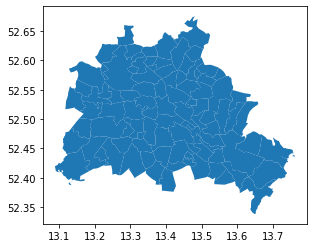

In [191]:
# Create the model with Coordinate Reference System 4326
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
# Save zones into the model
sm.zones = zones
sm.zones.plot()
sm.zones.sample(2)

### read and clean in block block shapefile

In [192]:
# Add building block shapefile
blocks = gpd.read_file(input_path + "zones/Einwohnerdichte_2020.shp")
blocks.to_crs(epsg=4326, inplace=True)
# remove blocks without geometry property
print("removing", sum(blocks.geometry == None), 
      "blocks with",
      round(sum(blocks[blocks.geometry == None]["ew2020"])),
      "inhabitants due to lack of geometry, e.g. block with schl5 =",
     blocks[blocks.geometry == None].iloc[0]["schl5"])
blocks = blocks[blocks.geometry != None]
blocks["zone"] = None

removing 127 blocks with 4863 inhabitants due to lack of geometry, e.g. block with schl5 = None


<AxesSubplot:>

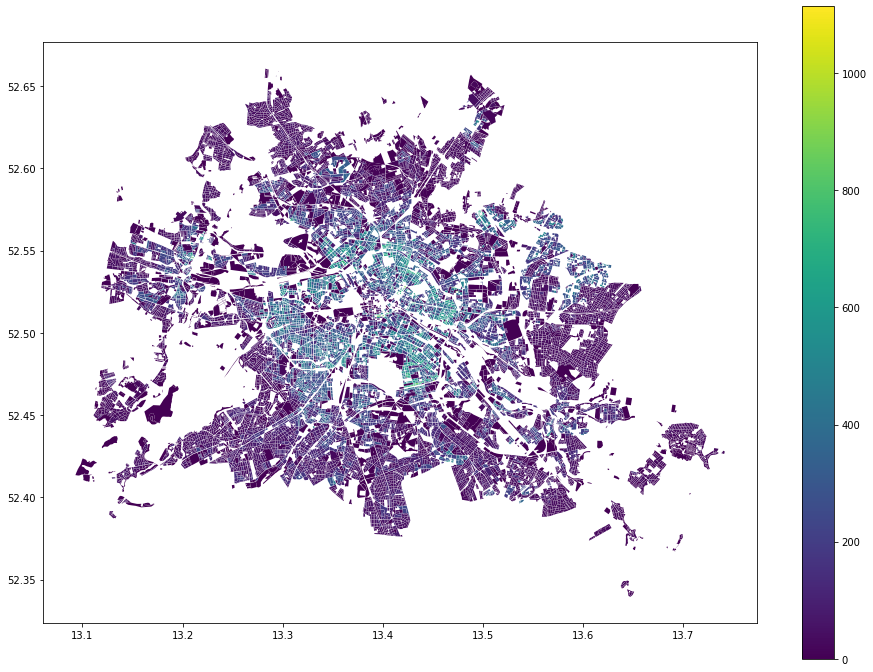

In [193]:
fig, ax = plt.subplots(figsize = (16,12))
blocks.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", legend=True)

### assign a zone to each block

In [194]:
# assign zone to each block
blocks["zone"] = \
    blocks['geometry']\
        .apply(lambda g: sm.zones.index[sm.zones.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)


Text(0.5, 1.0, 'Assignment of blocks to zones')

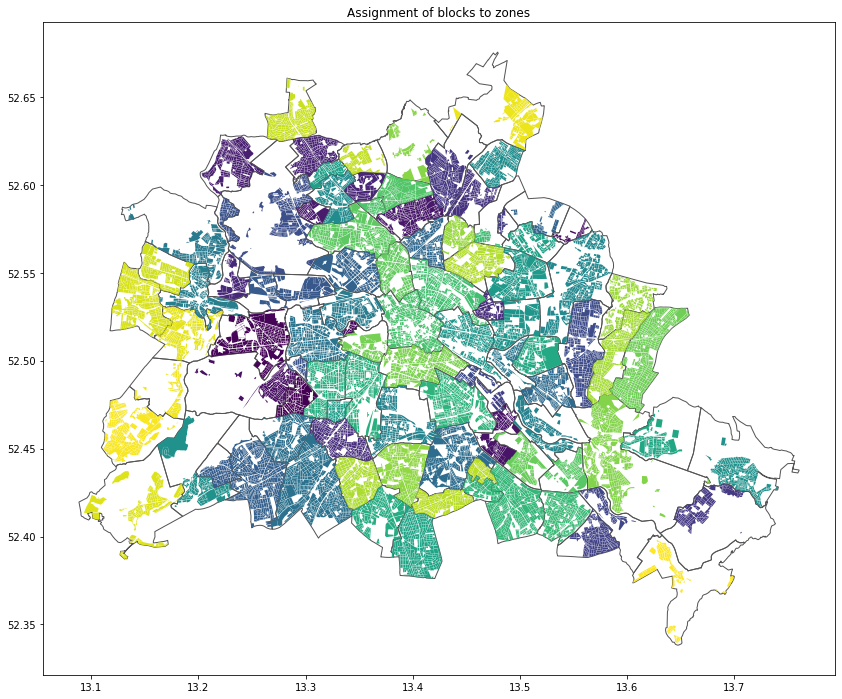

In [195]:
# plot
fig, ax = plt.subplots(figsize = (16,12))
sm.zones.plot(ax=ax, color="#ffffff00", edgecolor="#555")
blocks.plot(ax=ax, column='zone', cmap = "viridis", legend=False)
ax.set_title("Assignment of blocks to zones")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| 100%. Minutes elapsed: 00:17. Minutes remaining: 00:00. 

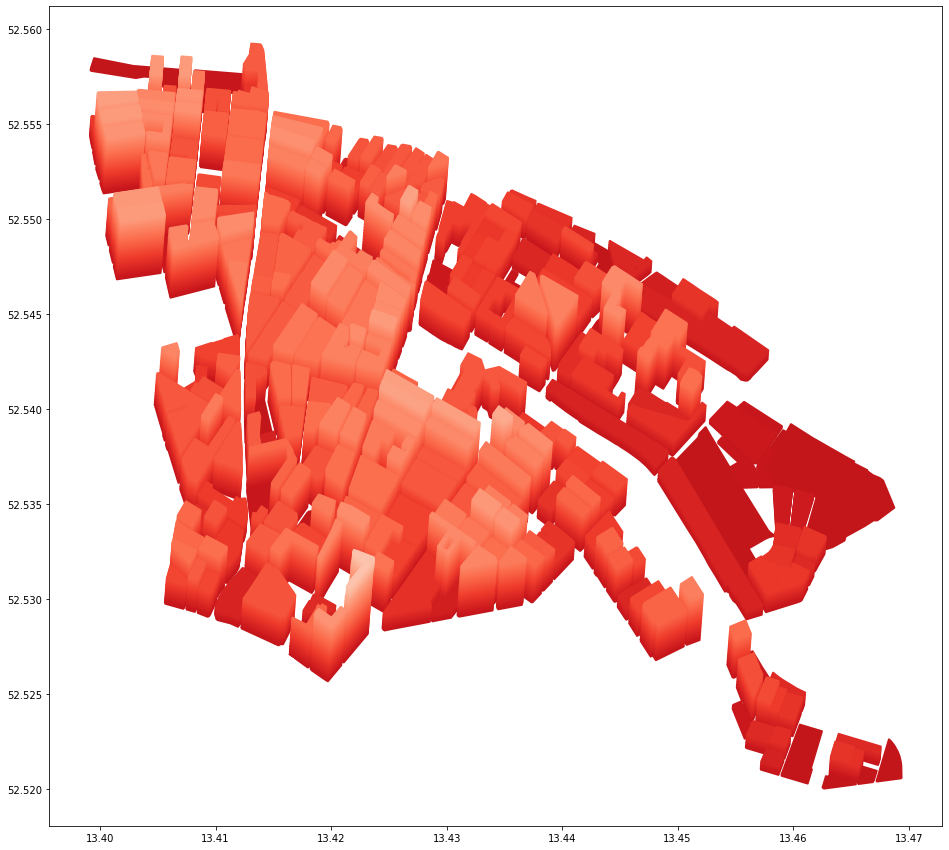

In [196]:
# some map art

from shapely.affinity import translate
from shapely.ops import unary_union
import time
sf = ["Prenzlauer Berg"]#["Pankow", "Prenzlauer Berg", "Mitte"]
spb = blocks[blocks["zone"].isin(sm.zones.index[sm.zones["nam"].isin(sf)])]
bspb = unary_union(list(spb.geometry.apply(lambda g: g.buffer(0.002))))
bspb = Polygon(bspb.exterior.coords)

fig, ax = plt.subplots(figsize = (16,16))
t0 = time.time()

# sm.road_links.geometry[list(sm.road_links.intersects(bspb))].apply(lambda g: g.buffer(0.00022).intersection(bspb)).plot(ax=ax, color ="grey")


maxHeight = max(spb["ew_ha_2020"])

nSteps = 50
cbuff = 40
cmap = plt.get_cmap('Reds_r', nSteps + cbuff)

for i in range(0,nSteps):
    # spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 1,8) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb["geometry"] = spb.apply(lambda row : translate(row["geometry"], 0.00001,0.00008) if (row["ew_ha_2020"] >= i/nSteps*maxHeight) else None, axis = 1)
    spb.plot(ax=ax, color = cmap(round(i + 0.5*cbuff)), edgecolor = cmap(round(i + 0.5*cbuff)), linewidth = 2)
    # spb.plot(ax=ax, column='ew_ha_2020', cmap = "viridis", linewidth = 2)
    helpers.printProgress(i=i, imax=nSteps, t=time.time(), t0=t0)





### for each zone: sum up population from blocks and create centroids weighted by population

In [197]:
sm.zones.tail(10)

,uuid,sch,nam,gdf,bezeich,geometry
87,DEBE12YYJ000000H,110000121208,Lübars,5010988.0,AX_KommunalesGebiet,"POLYGON ((13.36573 52.62529, 13.36583 52.62528..."
88,DEBE12YYJ000000B,110000121205,Frohnau,7839990.0,AX_KommunalesGebiet,"POLYGON ((13.28659 52.66007, 13.28717 52.65994..."
89,DEBE05YYQ000000D,110000050508,Falkenhagener Feld,6876159.0,AX_KommunalesGebiet,"POLYGON ((13.15567 52.56641, 13.15579 52.56639..."
90,DEBE05YYQ0000001,110000050504,Staaken,10887518.0,AX_KommunalesGebiet,"POLYGON ((13.14278 52.55219, 13.14321 52.55208..."
91,DEBE06YYA0000007,110000060607,Wannsee,23735618.0,AX_KommunalesGebiet,"POLYGON ((13.16655 52.44252, 13.16723 52.44112..."
92,DEBE05YYQ0000003,110000050509,Wilhelmstadt,10421573.0,AX_KommunalesGebiet,"POLYGON ((13.17876 52.53063, 13.17879 52.53063..."
93,DEBE03YY6000000D,110000030309,Buch,631.0,AX_KommunalesGebiet,"MULTIPOLYGON (((13.50544 52.61969, 13.50506 52..."
94,DEBE05YYQ000000F,110000050505,Gatow,10112629.0,AX_KommunalesGebiet,"POLYGON ((13.18715 52.48713, 13.18981 52.48433..."
95,DEBE05YYQ000000B,110000050506,Kladow,14779080.0,AX_KommunalesGebiet,"POLYGON ((13.13658 52.48481, 13.13669 52.48476..."
96,DEBE09YYO000000H,110000090915,Schmöckwitz,17124475.0,AX_KommunalesGebiet,"POLYGON ((13.62497 52.40099, 13.62543 52.40030..."


popCentroid (13.228250106615496, 52.580581987471035) not within polygon for zone 24 Konradshöhe


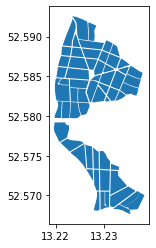

In [198]:
t0=time.time()
# sum up population from blocks to each zone and create centroids weighted by population
sm.zones["pop"] = 0
sm.zones["popCentroid"] = Point(0.0,0.0)
sm.zones["popCentroidOffset"] = LineString([Point(0.0,0.0), Point(0.0,0.0)])
sm.zones["popCentroidLat"] = 0.0
sm.zones["popCentroidLon"] = 0.0

for zoneIndex, zone in sm.zones.iterrows():
    blocksInZone = blocks[blocks["zone"]==zoneIndex]
    
    # obtain total zone population and save to sm.zones
    zonePopulation2020 = sum(blocksInZone["ew2020"])
    sm.zones.at[zoneIndex, "pop"] = zonePopulation2020
    
    # create weighted centroids based on where most people live within 
    weigthedCoords = {"lat": 0, "lon": 0}
    for blockIndex, block in blocksInZone.iterrows():
        weigthedCoords["lon"] += block["ew2020"] / zonePopulation2020 * block["geometry"].centroid.x
        weigthedCoords["lat"] += block["ew2020"] / zonePopulation2020 * block["geometry"].centroid.y
    
    sm.zones.at[zoneIndex, "popCentroidLat"] = weigthedCoords["lat"]
    sm.zones.at[zoneIndex, "popCentroidLon"] = weigthedCoords["lon"]
    popCentroid = Point(weigthedCoords["lon"], weigthedCoords["lat"])
    
    # check whether those centroids which are not within zone are still plausible
    if(not popCentroid.intersects(zone["geometry"])):
        print("popCentroid", popCentroid.coords[0], "not within polygon", "for zone", zoneIndex, zone["nam"])
        blocksInZone.plot()
    
    sm.zones.loc[zoneIndex, "popCentroid"] = popCentroid
    # add a line between actual centroid and pop centroid
    sm.zones.loc[zoneIndex, "popCentroidOffset"] = LineString([zone["geometry"].centroid, popCentroid])
    # helpers.printProgress(i=zoneIndex, imax=len(sm.zones), t=time.time(), t0=t0)

Text(0.5, 1.0, 'Zones centroids vs population weigthed centroids')

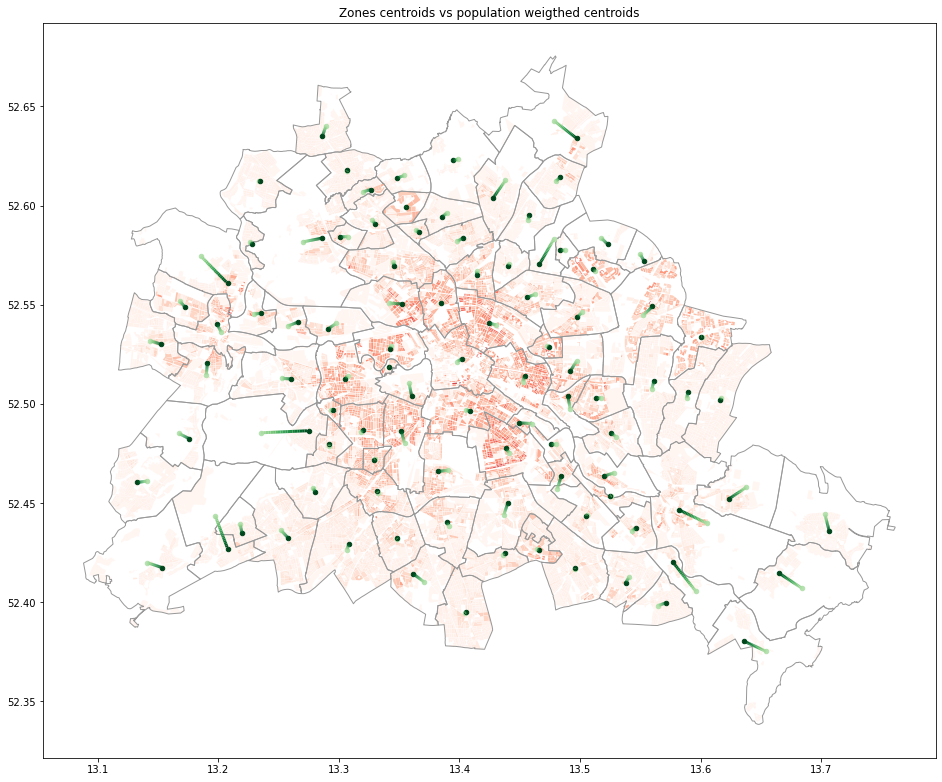

In [199]:
# show zones and popCentroids and their offsets from real geometrical centroids
fig, ax = plt.subplots(1, 1, figsize=(16,16))
blocks.plot(ax=ax, column='ew_ha_2020', cmap = "Reds")
# add zone borders and a bit of opacity
sm.zones.geometry.plot(ax=ax, color = "#ffffff33", edgecolor="#999999")
nSteps = 20
cbuff = 10
cmap = plt.get_cmap('Greens_r', nSteps + cbuff)
gpd.GeoSeries(sm.zones.geometry.centroid, crs=sm.epsg).plot(ax=ax, color = cmap(nSteps), markersize = 20)
for i in range(1,nSteps):
    l = [helpers.segmentLine(x, i, nSteps) for x in sm.zones.popCentroidOffset]
    gpd.GeoSeries(l, crs=sm.epsg).plot(ax=ax,color=cmap(i), linewidth=3)
gpd.GeoSeries(sm.zones.popCentroid, crs=sm.epsg).plot(ax=ax, color = cmap(0), markersize = 20)
ax.set_title("Zones centroids vs population weigthed centroids")

<AxesSubplot:>

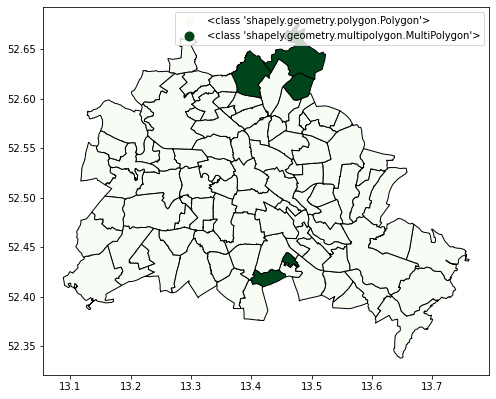

In [201]:
# plot zones by geometry type
sm.zones.plot(column = np.array([type(x) for x in sm.zones["geometry"]]),  cmap = "Greens",  edgecolor="black", legend=True, figsize = (8,8))

## Add zone statistics weighted by population or block square meters


### employment per planungsraeume

In [202]:
blocks.head(2)

,schl5,ew2020,flalle,ew_ha_2020,typklar,area_calc,geometry,zone
0,0100980011000100,3.0,4624.0,6.487889,Freie Zeilenbebauung mit landschaftlichem Sied...,4623.945832,"POLYGON ((13.36830 52.53464, 13.36857 52.53475...",68.0
1,0100980011000300,21.0,5604.0,37.473233,Geschosswohnungsbau der 1990er Jahre und jünger,5603.674449,"POLYGON ((13.36732 52.53556, 13.36693 52.53592...",68.0


,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry
broker Dow,,,,,,
01011101,Mitte,Stülerstraße,14.06.2006,366755.50,01011101,"POLYGON ((13.33889 52.50542, 13.33986 52.50562..."
01011102,Mitte,Großer Tiergarten,14.06.2006,3009397.45,01011102,"POLYGON ((13.33140 52.51288, 13.33141 52.51285..."
01011103,Mitte,Lützowstraße,14.06.2006,522356.58,01011103,"POLYGON ((13.34923 52.50307, 13.34972 52.50343..."
01011104,Mitte,Körnerstraße,14.06.2006,338383.45,01011104,"POLYGON ((13.36254 52.49966, 13.36265 52.49989..."
01011105,Mitte,Nördlicher Landwehrkanal,14.06.2006,934609.72,01011105,"POLYGON ((13.35159 52.50976, 13.35199 52.50978..."


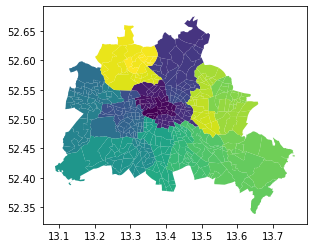

In [203]:
plr = gpd.read_file(input_path + "zones/lor_planungsraeume")
plr.to_crs(epsg=sm.epsg, inplace=True)
plr.plot(cmap="viridis")
plr.set_index(plr['broker Dow'], inplace=True)
plr.head()

['01 Mitte',
 '02 Friedrichshain-Kreuzberg',
 '03 Pankow',
 '04 Charlottenburg-Wilmersdorf',
 '05 Spandau',
 '06 Steglitz-Zehlendorf',
 '07 Tempelhof-Schöneberg',
 '08 Neukölln',
 '09 Treptow-Köpenick',
 '10 Marzahn-Hellersdorf',
 '11 Lichtenberg',
 '12 Reinickendorf']

In [408]:
# read in employment data and create best guess for each plr employment
# only number of Niederlassungen per plr per Beschäftiungsgrößenklassen is given
employment = pd.read_excel(input_path + 'unternehmen_plr.xlsx')

plr['Bezirk'] = [employment['Bezirk'][employment['broker Dow'] == int(p)].iloc[0] for p in plr['broker Dow']]

# create guess for total employment per plr: 2/3 lower bound + 1/3 upper bound
employment['guess'] = \
    employment['0 bis unter 10'] * (0*2+10*1)/3 + \
    employment['10 bis unter 50'] * (10*2+50*1)/3 + \
    employment['50 bis unter 250'] * (50*2+250*1)/3 + \
    employment['250 und mehr'] * (250*2+300*1)/3

# create bezirke gdf based on information of employment data
bezirke = gpd.GeoDataFrame({'Bezirk': employment['Bezirk'].unique()}, 
    geometry=[unary_union([x.buffer(0.0001) for x in plr['geometry'][plr['Bezirk']==b]]) for b in plr['Bezirk'].unique()], 
    crs=sm.epsg)
bezirke['guess_sum'] = [sum(employment['guess'][employment['Bezirk']==b]) for b in bezirke['Bezirk']]
bezirke['real_employment'] = [employment['Beschaeftige Bezirk'][employment['Bezirk']==b].iloc[0] for b in bezirke['Bezirk']]
bezirke['correction_factor'] = bezirke['real_employment'] / bezirke['guess_sum']
print('correction_factor', list(bezirke['correction_factor']))

# apply correction factor to guess
employment['corrected_guess'] = employment.apply(lambda row: (row['guess'] * bezirke['correction_factor'][bezirke['Bezirk'] == row['Bezirk']]).iloc[0], axis=1)
# employment = gpd.GeoDataFrame(employment, geometry=

correction_factor [1.2328559775219794, 0.9351130332219382, 0.8306666961404129, 0.8592569519170868, 1.059058264212017, 0.8693223739563783, 0.9118966577814229, 0.7603260094164646, 0.8795420013023659, 0.9083001562263772, 0.8821248122354225, 0.9726884729753369]


In [410]:
# assign zone to each block
blocks["plr"] = \
    blocks['geometry']\
        .apply(lambda g: plr.index[plr.intersects(g.centroid)])\
        .apply(lambda zi: zi[-1] if len(zi)>0 else None)

# sum total are of blocks within plr
plr['block_area_calc'] = [sum(blocks['area_calc'][blocks['plr']==i]) for i in plr.index]

# calculate share of each block area in plr area 
blocks['plr_share'] = [a/plr['block_area_calc'][plr.index==p][0] if not p==None else 0 for p,a in zip(blocks['plr'], blocks['area_calc'])]
print("should be all around 1:", min([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]), max([sum(blocks['plr_share'][blocks['plr']==i]) for i in plr.index]))
print("plr not included:", [x for x in plr.index if x not in list(blocks['plr'])])

should be all around 1: 0.9999999999999989 1.0000000000000007
plr not included: []


In [411]:
# now obtain employment guess for each block 
blocks['plr_employment'] = [employment['corrected_guess'][employment['broker Dow']==int(p)].iloc[0] if not p==None else 0 for p in blocks['plr']]
blocks['employment'] = blocks['plr_employment'] * blocks['plr_share']

# now sum data from building block level to zone level
sm.zones['employment'] = [sum(blocks['employment'][blocks['zone']==i]) for i in sm.zones.index]


In [412]:
employment.head()

,plr,broker Dow,0 bis unter 10,10 bis unter 50,50 bis unter 250,250 und mehr,Gesamt,Bezirk,Beschaeftige pro Niederlassung,Beschaeftige Bezirk,guess,corrected_guess
0,01000000 Mitte ohne LOR-Zuordnung,1000000,128,26,2,0,156,01 Mitte,14.690679,408063,1266.666667,1561.617572
1,01011101 Stülerstraße,1011101,340,56,23,8,427,01 Mitte,14.690679,408063,7256.666667,8946.424877
2,01011102 Großer Tiergarten,1011102,35,10,4,1,50,01 Mitte,14.690679,408063,1083.333333,1335.593976
3,01011103 Lützowstraße,1011103,566,75,33,9,683,01 Mitte,14.690679,408063,9886.666667,12188.836098
4,01011104 Körnerstraße,1011104,447,63,17,6,533,01 Mitte,14.690679,408063,6543.333333,8066.987613


,BEZIRKSNAM,PLANUNGSRA,DATUM_GUEL,FLAECHENGR,broker Dow,geometry,block_area_calc
broker Dow,,,,,,,
01011101,Mitte,Stülerstraße,14.06.2006,366755.50,01011101,"POLYGON ((13.33889 52.50542, 13.33986 52.50562...",1.865586e+05
01011102,Mitte,Großer Tiergarten,14.06.2006,3009397.45,01011102,"POLYGON ((13.33140 52.51288, 13.33141 52.51285...",1.126383e+06
01011103,Mitte,Lützowstraße,14.06.2006,522356.58,01011103,"POLYGON ((13.34923 52.50307, 13.34972 52.50343...",3.540167e+05
01011104,Mitte,Körnerstraße,14.06.2006,338383.45,01011104,"POLYGON ((13.36254 52.49966, 13.36265 52.49989...",2.066860e+05
01011105,Mitte,Nördlicher Landwehrkanal,14.06.2006,934609.72,01011105,"POLYGON ((13.35159 52.50976, 13.35199 52.50978...",3.190362e+05


Text(0.5, 1.0, 'employment per zone')

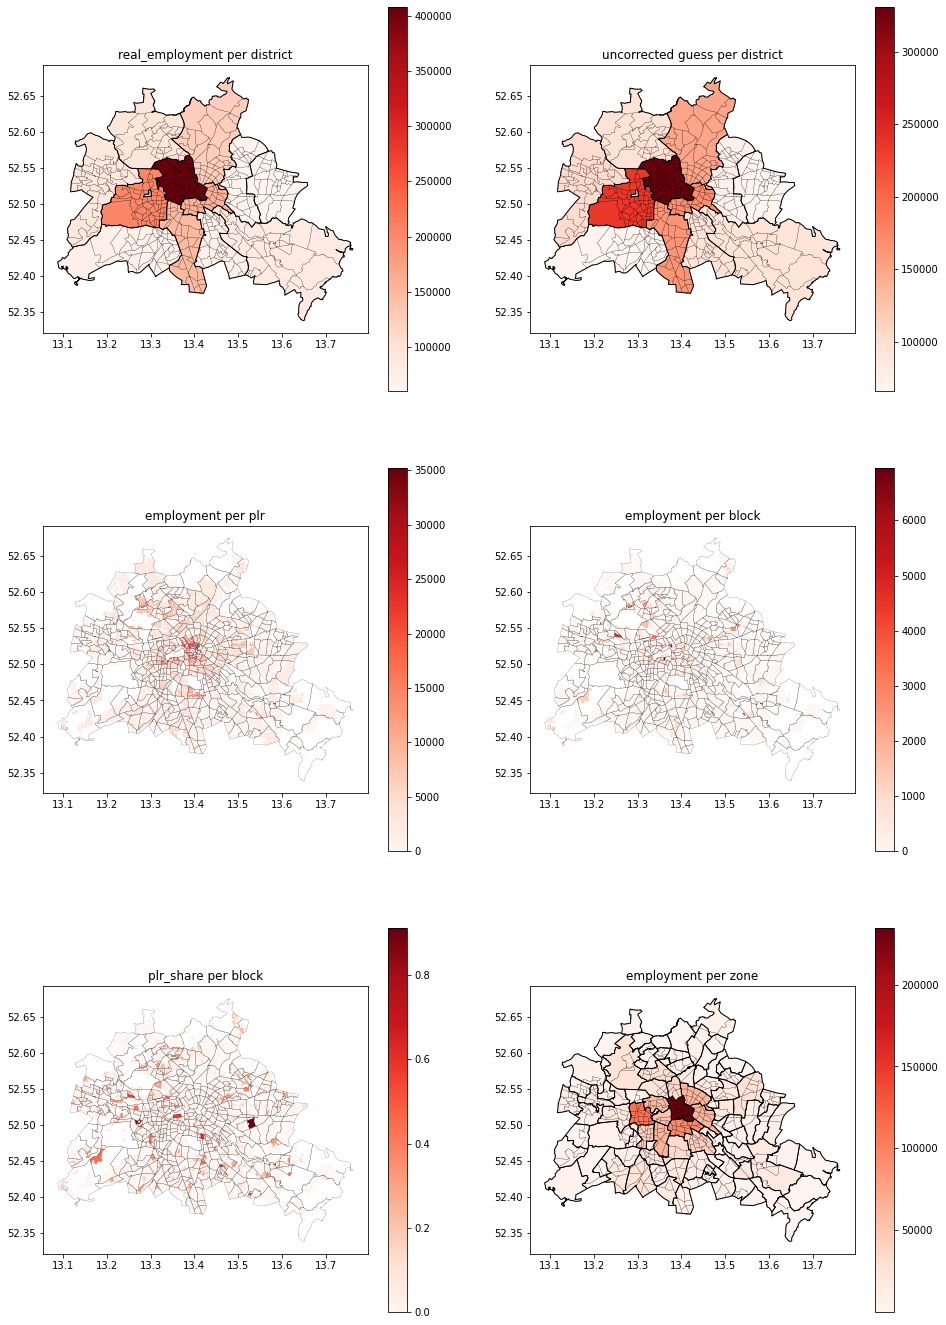

In [417]:
# this plot should be adapted to show the process. it could show the following:
# employment data by district (Bezirk)
# guess based on companies for plr
# corrected guess for plr
# employment per building 
# employment per zone

fig, ax = plt.subplots(3, 2, figsize=(16,24))
bezirke.plot(ax=ax.flat[0], column='real_employment', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
bezirke.plot(ax=ax.flat[1], column='guess_sum', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
blocks.plot(ax=ax.flat[2], column='plr_employment', cmap="Reds", legend=True)
blocks.plot(ax=ax.flat[3], column='employment', cmap="Reds", legend=True)
blocks.plot(ax=ax.flat[4], column='plr_share', cmap="Reds", legend=True)
sm.zones.plot(ax=ax.flat[5], column='employment', cmap="Reds", legend=True, edgecolor="black", linewidth=1)
plr.plot(ax=ax.flat[0], color='None', edgecolor="black", linewidth=0.15)
plr.plot(ax=ax.flat[1], color='None', edgecolor="black", linewidth=0.15)
plr.plot(ax=ax.flat[2], color='None', edgecolor="black", linewidth=0.15)
plr.plot(ax=ax.flat[3], color='None', edgecolor="black", linewidth=0.15)
plr.plot(ax=ax.flat[4], color='None', edgecolor="black", linewidth=0.15)
plr.plot(ax=ax.flat[5], color='None', edgecolor="black", linewidth=0.15)
ax.flat[0].set_title("real_employment per district")
ax.flat[1].set_title("uncorrected guess per district")
ax.flat[2].set_title("employment per plr")
ax.flat[3].set_title("employment per block")
ax.flat[4].set_title("plr_share per block")
ax.flat[5].set_title("employment per zone")

### Next steps. Create attractor estimation.

Create attractor fields. <br>
Use school locations. (shapefile already there) <br>
Use Business locations (look up via OSM) <br>
Use Shopping locations (look up via OSM) <br>
Maybe use other data source like traffic data? <br>
Maybe use block height? <br>
Get Data on Mode Choice / Car Ownership for each zone? <br>

## Save model

In [83]:
# remove additional geometry from dataframe, as otherwise an error is thrown when saving. 
sm.zones = sm.zones.drop(columns = [x for x in ['popCentroid', 'popCentroidOffset'] if x in sm.zones.columns])

In [84]:
# Saving model zones as geojson
sm.to_json(model_path + 'zones', only_attributes=['zones'], encoding='utf-8')

to_hdf(overwriting): 100%|██████████| 32/32 [00:01<00:00, 23.71it/s]
